# Example Data Analysis for Water Ethics Web Engine Framework

This notebook demonstrates the features and data types to support the post-play analysis of applications using the Water Ethics Web Engine by Ewing, Demir.

Classes, methods, and supporting functions are imported from `WEnalytics` (Ethics Engine Analytics).

In [1]:
import WEnalytics as WE2

Other common python packages need to be imported alongside.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=4)

## Instantiate Experiment Class and Get Data From Database

Here we **instantiate a single variable of `class Experiment`**

In [7]:
sampleBuild = WE2.Experiment('https://hydroinformatics.uiowa.edu/lab/WaterEthicsWebEngine/sampleBuild/')

However, a study may have multiple experiments or groups of participants that gave feedback on different sets of scenarios. 
For example, each experiment has a corresponding and separate directory on the server.
The unique directory names are also keys in the web database. 

```python
card = WE2.Experiment('.../WaterEthicsWebEngine/card')
moon = WE2.Experiment('.../WaterEthicsWebEngine/moon')
egg  = WE2.Experiment('.../WaterEthicsWebEngine/egg')
deer = WE2.Experiment('.../WaterEthicsWebEngine/deer')
```

After instantiation, use the `GET()` method to injest experimental data from the web database and metadata from the experiment's directory.

In [17]:
sampleBuild.GET();

These data are structured as object attributes.
Some attributes of the `Experiment` provide descriptive information, which  are listed below:
 - `Experiment.author`
 - `Experiment.exp_meta`
 - `Experiment.infoBar`
 
These are the same metadata used in the html/javascript to build the webpage.
See for youself:

In [18]:
pp.pprint(sampleBuild.infoBar)

{   'categories': [   'Federal and State Costs',
                      'Private Costs',
                      'Injuries',
                      'Deaths',
                      'Environmental Impact'],
    'colorByCat': ['default', 'default', '#aa0000b3', '#aa0000b3', '#3957ab'],
    'defaultColor': '#2ecc71',
    'header': 'Damages',
    'nCategories': 5}


The `Experiment` class also has results containers.
`Experiment.users` is a dictionary where keys are the unique ids from the web database, while the values are of `class User`. `User` holds the voting results of that particular user. For example:

In [19]:
print('id: ',sampleBuild.users['33-1591642145-172.29.41.152-1836529411'].id)
print(sampleBuild.users['33-1591642145-172.29.41.152-1836529411'].responses)

id:  33-1591642145-172.29.41.152-1836529411
{'6': 'R', '3': 'L', '2': 'R', '5': 'R', '4': 'R'}


Users, however, are not identifiable through their unique ids.
Instead, results derive meaning through there aggregation.
As such, user voting results are combined into a pandas table of False (0, or Left) and True (1, or Right.)

In [22]:
sampleBuild.BoolResults();
sampleBuild.boolTable.astype(int).head()

,2,3,4,5,6,event
0,0,1,0,0,0,8
1,0,1,0,1,1,11
2,0,1,1,0,0,12
3,0,1,1,0,1,13
4,1,0,1,1,1,23


Notice, that the rows of the table show an individual's vote (Left or Right) with a 0 or 1 for each scenario presented (in this case scenarios 2, 3, 10, 15, and 16.)
Thus the number of possible vote combinations, $\mathcal{C}$, is 

$$\mathcal{C}= 2^{N_{scenarios}}$$

where $N_{scenarios}$ is the number of scenarios presented to participants in the experiment. In this example, $N_{scenarios} = 5$. Thus,

$$\mathcal{C} = 2^{5} = 32$$

Each combination can be represented in both binary (base 2) and decimal (base 10). The **event** column is base 10 representation of the voting result for an individual.


Following this understanding, each participants' individual results can be grouped by their event number.
A pixel figure can communicate the qualitative grouping of participant voting blocks.

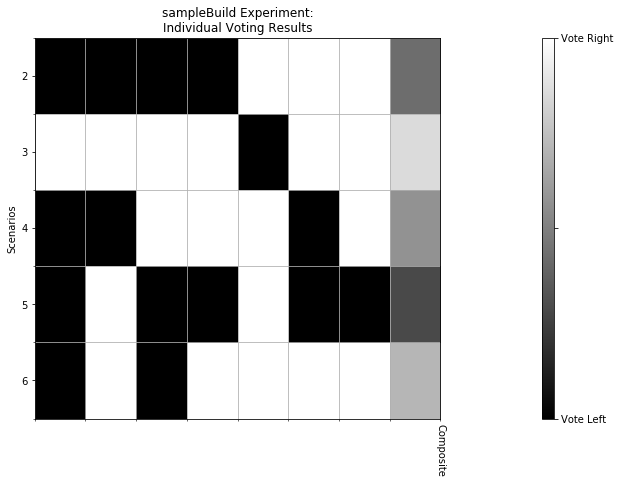

In [23]:
fig,ax=sampleBuild.PixelFigure()
plt.show()

## Estimate Models from Voting Data

Here we use Thurstone's Law of Comparative Judgement Case V.
The general model for Thurstone's mean quality difference of A - B, $\mu_{AB}$, is calculated as:

$$\mu_{AB} = \sigma_{AB} \Phi^{-1} \left( \frac{C_{A,B}}{C_{A,B} + C_{B,A}}\right)$$

Where $\Phi^{-1}(x)$ is the inverse CDF of the standard normal (the *probit*), and $C_{A,B}$ and $C_{B,A}$ are the number of votes for each option (choose A over B and vice versa.) $\sigma_{A,B}$ varies by each case Thurstone presented. Case V is the simplest and most popular, and states that:

$$\sigma^{2}_{AB} = \sigma^{2}_{A} + \sigma^{2}_{B} = 1$$

Doing so makes simplifies the equation for the mean utility difference to be:

$$\hat{\mu}_{AB} = \Phi^{-1} \left( \frac{C_{A,B}}{C_{A,B} + C_{B,A}}\right)$$

$$ $$
Using the average (composite) pixel value as calculated for the image above from the boolean allows us to estimate the mean utilities from the group for each scenario, without having to find $C_{A,B}$ and $C_{B,A}$ explicitly.

Mean differences can be related to scenario belief features as:

$$ \mu_{AB} = \beta^T (X_A - X_B) $$

Where $X_A$ and $X_B$ are vectors of the belief features for option A and option B respectively. Thus, a model, $\beta^T$, of the group's preference towards outcomes can be learned using multiple linear regression given that: 

$$\begin{bmatrix} 
    \mu_{AB,1} \\
    \mu_{AB,2} \\
    \vdots \\
    \mu_{AB,n}
   \end{bmatrix} = \beta^{T} \begin{bmatrix} (X_A - X_B)_{1} \\
   (X_A - X_B)_{2} \\
   \vdots \\
   (X_A - X_B)_{n} 
   \end{bmatrix}$$

Instantiate a variable of class `Models` by giving it the categories that the model(s) pertain to.
`Models` is a child of the built in `dict` class.

In [16]:
models = WE2.Models(['Public\nCosts', 'Private\nCosts', 'Injuries', 'Deaths', 'Environ.\nImpact'])

A linear model can be estimated using the voting results and the methodology outlined above.
The `LinearModel` method first calculates the mean quality scores for each scenario, $\mu_{AB,i}$.
A linear regression model is then estimated for $\beta^T$ using **scikit-learn `linear_model` module**.
The entire scikit-learn linear model object is stored in `self.model`.
Beta coefficients are additionally stored in `self.beta`.
For the purpose of our analysis, these values can be collected in a variable of class `Models`.

In [24]:
sampleBuild.LinearModel();
models['sampleBuild'] = sampleBuild.beta;

The model class holds the beta values in two forms: key-value pars and in a table.

In [25]:
models.UpdateTable()
models['Average'] = models.table.loc['Average'].values
models.UpdateTable()
models.table

,Public Costs,Private Costs,Injuries,Deaths,Environ. Impact
sampleBuild,0.350332,0.665294,-0.736181,-0.210807,0.04911
Average,0.350332,0.665294,-0.736181,-0.210807,0.04911


You can add any arbitrary beta model to the dict-like variable.

In [26]:
models['public'] = np.array([-1,0,0,0,0])
models['private'] = np.array([0,-1,0,0,0])
models['injuries'] = np.array([0,0,-1,0,0])
models['deaths'] = np.array([0,0,0,-1,0])
models['environ'] = np.array([0,0,0,0,-1])

The `UpdateTable()` method will include all models defined in the dictionary when calculating the Average model.
This may not be the ideal behavior when inserting in numerous manual entry models.
To avoid this, manually insert rows into the pandas DataFrame.

In [28]:
models.table.loc['public'] = models['public']
models.table.loc['private'] = models['private']
models.table.loc['injuries'] = models['injuries']
models.table.loc['deaths'] = models['deaths'] 
models.table.loc['environ'] = models['environ']
models.table

,Public Costs,Private Costs,Injuries,Deaths,Environ. Impact
sampleBuild,0.350332,0.665294,-0.736181,-0.210807,0.04911
Average,0.350332,0.665294,-0.736181,-0.210807,0.04911
public,-1.000000,0.000000,0.000000,0.000000,0.00000
private,0.000000,-1.000000,0.000000,0.000000,0.00000
injuries,0.000000,0.000000,-1.000000,0.000000,0.00000
deaths,0.000000,0.000000,0.000000,-1.000000,0.00000
environ,0.000000,0.000000,0.000000,0.000000,-1.00000


## Using Models to Make a Prediction

The class `Models` data structure can be used to make predictions with the models on new scenarios.
Use the `Predict` method to use return *predicted* mean quality scores from each model.
By convention a quality score:
- less than 0 means the model votes **Left**
- greater than 0 means the model votes **Right**

In [29]:
pp.pprint(models.Predict(np.array([-2,-4,5,6,-7])))

{   'Average': -8.651361814906892,
    'deaths': -6,
    'environ': 7,
    'injuries': -5,
    'private': 4,
    'public': 2,
    'sampleBuild': -8.651361814906892}


### Using Models to Make Predictions on a Selection of Scenarios

Collecting the models' predictions along a selection of scenarios can help to understand the behaviour of the learned models.
Below we use the learned models to make decisions on 17 randomly generate scenarios.

In [35]:
# randomly generate integers between -10 and 10 for each each of the 17 scenarios along each category.
scenarios = np.random.randint(-10,10,(17,5))

Store the calculated utility differences for each scenario from each model in a DataFrame, in this example in `modelVotes`.
Once the raw utility scores are collectected, logic operations can be performed to convert the raw utility scores into Left 0 and Right 1. 
Ties, represented as 0.5 can also be included. 
(In the case of manually defined models, ties are more common.)

In [46]:
# instantiate DataFrame
modelVotes = pd.DataFrame(index=models.table.index)

# Make predictions on each scenario using each model
for s in range(scenarios.shape[0]):
    modelVotes[s] = modelVotes.index.map(models.Predict(scenarios[s]))
    
# Identify ties
ties = modelVotes == 0

# Greater than 0 means vote right, True, or 1.0
modelVotes = modelVotes > 0

# Insert ties back into results table
modelVotes[ties] = 0.5

# Make cell format consistent
modelVotes = modelVotes.astype(float)

# Can visualize similarities between the models just by converting the background on the cells.
modelVotes.style.background_gradient(cmap='gray')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
sampleBuild,0,1,0,1,1,0,1,0,0,1,0,1,1,1,1,1,0
Average,0,1,0,1,1,0,1,0,0,1,0,1,1,1,1,1,0
public,1,0,1,0,0,0,1,1,0,0,0.5,0,1,0,0,1,1
private,1,0,0.5,0,1,1,1,1,1,0,1,1,0,0,0,1,0
injuries,0,1,0,0,1,0,1,0,0,1,1,1,1,0,0,1,0
deaths,1,1,1,1,0,0,0,0,0,0,0,0.5,1,1,1,0.5,0
environ,0,1,0,1,0,1,0,1,1,0,1,0,1,1,1,0,1


This concludes a tutorial of the basic capabilities of the analytics of our the Ethics Engine.
Please refer to the source `WEnalytics.py` as well.
Let us know if you have any questions.

![](../app/images/footer/uihilab_logo.png)